# MNIST 2: Ein Neuronales Netzwerk für MNIST

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mnist import MnistDataset 

%matplotlib inline

## Daten einlesen

Wir lesen unsere Daten mit unserer Klasse MnistDataset ein:

In [2]:
# Laden der Trainings- und Testdaten
mnist_train = MnistDataset('mnist_train.csv')
mnist_test  = MnistDataset('mnist_test.csv')

#### Die ersten Ziffern...

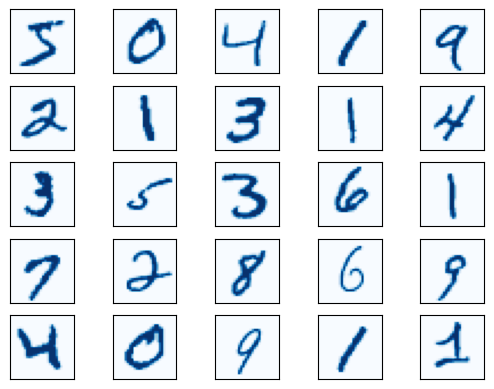

In [3]:
mnist_train.plot_list(5,5)
plt.show()  

#### Einige Funktionen zur Erstellung von Grafiken

Wir definieren zusätzlich einige spezielle Funktionen zur grafischen Darstellung:

In [4]:
def show_network_result(row):
    data = test_data_list[row].split(',')[1:]
    value =  test_data_list[row][0]
    output = network.forward((np.asfarray(data) / 255.0 * 0.99) + 0.01)
    show_output(output,value)
    pass

def show_output(output,value):
    y_pos = np.arange(len(output))
    
    plt.bar(y_pos, output, align='center', alpha=0.5)
    plt.xticks(range(9))
    plt.xlabel('Output-Neuronen')
    plt.ylabel('Wert des Outputs')    
    plt.title(value )
    
    plt.show()
    pass

def show_number(data):
    """
    Plottet den Eintrag mit dem angegebenen Index.
    """
    for r in range(data):
        for c in range(cols):
            plt.subplot(rows,cols,r*rows + c + 1)
            index = r*rows + c + offset
            label = self.data[index,0]
            bild_daten = self.data[index,1:].reshape(28,28)
            #plt.title(f'Number = {label}')                
            plt.imshow(bild_daten,cmap='Blues')

## Ein Neuronales Netz mit drei Schichten

Wir verwenden dasselbe neuronale Netzwerk wie bei der Erkennung der Iris-Blüten: Drei Schichten mit einer sigmoidalen Transferfunktion. Wie wir festgestellt habe, ist dies die einfachste Gestalt, die ein sinnvolles neuronales Netzwerk annehmen kann, denn wir brauchen mindesten eine verborgene Schicht und eine nicht-lineare Übergangsfunktion.

In [13]:
  class MLP:
    def __init__(self, *nodes: list[int]) -> None:
        ''' Setzen der Parameter des MLP. Gewichte werden zufällig erzeugt. '''
        self.inodes, self.hnodes, self.onodes = nodes

        self.wih = np.random.normal(self.hnodes, self.inodes)
        self.who = np.random.normal(self.onodes,self.hnodes)

        #self.wih = np.random.rand(0.0, pow(self.hnodes, -0.5), (self.hnodes, self.inodes))
        #self.who = np.random.normal(0.0, pow(self.onodes, -0.5), (self.onodes, self.hnodes))

        self.transfer = lambda x: 1/(1 + np.exp(-x)) # Die Sigmoid-Funktion
        pass

    def fit(self, inputs_list: np.ndarray, targets_list: np.ndarray,lr: float = 0.2) -> None :
        ''' Training des Neuronalen Netzwerks '''
   
        inputs =  np.transpose(np.array(inputs_list, ndmin=2))
        targets = np.transpose(np.array(targets_list, ndmin=2))

        hidden_inputs = np.dot(self.wih, inputs)
        hidden_outputs = self.transfer(hidden_inputs)

        final_inputs = np.dot(self.who, hidden_outputs)
        final_outputs = self.transfer(final_inputs)

        output_errors = targets - final_outputs
        hidden_errors = np.dot(self.who.T, output_errors)
        
        # Backpropagation
        self.who += lr * np.dot((output_errors * final_outputs * (1.0 - final_outputs)), np.transpose(hidden_outputs))
        self.wih += lr * np.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), np.transpose(inputs))
    
        pass

    def forward(self, inputs_list: np.ndarray):
        ''' Abfrage des Neuronalen Netzwerks '''
        inputs = np.array(inputs_list, ndmin=2).T
        hidden_inputs = np.dot(self.wih, inputs)
        hidden_outputs = self.transfer(hidden_inputs)
        final_inputs = np.dot(self.who, hidden_outputs)
        final_outputs = self.transfer(final_inputs)
        return np.concatenate(final_outputs).ravel()

    def predict(self, inputs: np.ndarray) -> int:
        return np.argmax(self.forward(inputs))

    def performance(self,test_data):
        '''
        Testet die Leistung des Neuronalen Netzwerkes mit Hilfe von Testdaten. 
        Es wird ein Wert fuer die Zuverlaessigkeit und die Liste der falschen Zuordnungen zurueckgegeben.
        '''
        fails = []
        for n,record in enumerate(test_data):
            correct_label = int(record[0])
            inputs = (np.asfarray(record[1:]) / 255.0 * 0.98) + 0.01
            outputs = self.forward(inputs)
            label = np.argmax(outputs)
            if (label != correct_label):
                fails.append(n)
        performance =  1. - (len(fails) / len(test_data))
        return performance , fails

    def save(self,file: str) -> None:
        '''Speichert die Gewichte des Netzwerks'''
        with open(file + '.npy', 'wb') as f:
            np.save(f,self.wih, allow_pickle=True)
            np.save(f,self.who, allow_pickle=True)
        print("Gewichte wurden gespeichert")            

    def load(self,file: str) -> None:
        '''Lädt die Gewichte des Netzwerks'''        
        with open(file + '.npy', 'rb') as f:
            self.wih = np.load(f)
            self.who = np.load(f)
        print("Gewichte wurden geladen")      
        
    def __str__(self) -> str:
        return "in -> hidden:" + np.array2string(self.wih) +"\nhidden -> out" + np.array2string(self.who) 



### Aufbau des Netzwerks

Ein- und Ausgabeschicht sind durch das Problem definiert:

* 28x28 = 784 Neuronen in der __Eingabeschicht__
* 10 Neuronen in der __Ausgabeschicht__, eines für jede Ziffer von 0 bis 9

Bei der verborgenen Schicht sind wir frei, und hier beginnt die Arbeit des Data Scientists. Es gibt viele Möglichkeiten zum Experimentieren. Wir setzen die Anzahl der Neuronen auf 100, was einen guten Mittelwert ergibt, denn in jeder Schicht findet nun eine Reduktion auf etwa 10 % statt.

* 100 Neuronen in der __verborgenen Schicht__

Insgesamt sieht unser Netzwerk also so aus:

In [6]:
mlp = MLP(28*28,100,10)

## Skalierung der Daten

Unsere Daten liegen als Grauwerte zwischen 0 und 255 vor. Wir brauchen für unsere Rechnungen Werte zwischen 0 und 1. Dabei können Werte von genau 0 oder 1 bei unseren Berechnungen zu Problemen führen, daher skalieren wir die Daten genauer auf den Bereich zwischen 0.01 und 0.99:

In [7]:
scale = lambda record: (np.asfarray(record[1:]) / 255.0 * 0.98) + 0.01

##  Training des Netzes

Mit der Definition des Netzwerks und einer geeigneten Skalierungsfunktion für die Anpassung der Daten ist unsere Arbeit getan. Jetzt lassen wir das neuronale Netzwerk arbeiten, bzw. trainieren:

In [8]:
def train(epochs = 1):
    for e in range(epochs):
        for record in mnist_train:
            input = scale(record)
            targets = np.zeros(10) + 0.01
            targets[int(record[0])] = 0.99
            
            mlp.fit(input, targets)
            pass
        print(f'Durchlauf #{e+1} / {epochs} fertig')

train(1)

Durchlauf #1 / 1 fertig


### Ein einfacher Test

Wir probieren unser trainiertes Netzwerk an einem zufällig gewählten Test-Zeichen aus:

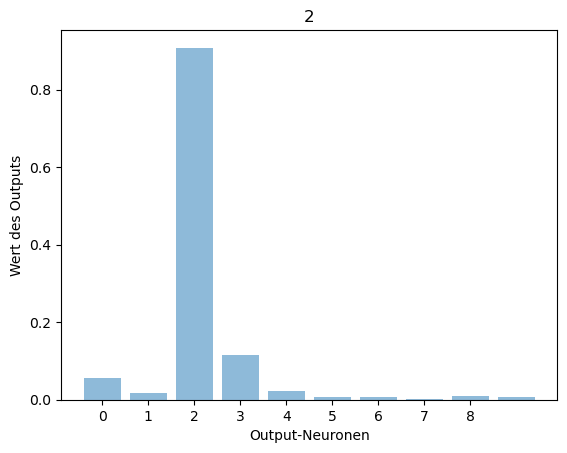

In [9]:
row = np.random.randint(10000)
data = mnist_test[row]
value =  data[0]
output = mlp.forward(scale(data))

show_output(output,value)

## Wie gut ist der Klassifizierer?

### Eine Funktion zum Test der Performance
Wir definieren einen Test, der uns die Güte des trainierten Netzwerks bestimmt. Wir lassen dazu alle 10.000 Daten aus dem test-Datensatz durch das Netzwerk laufen und vergleichen es mit dem erwarteten Ergebnis. Der Prozentsatz der richtigen Lösungen steht für die Qualität der Lösung.

In [10]:
def performance_test(network,test_data):
    '''
    Testet die Leistung des Neuronalen Netzwerkes mit Hilfe von Testdaten. 
    Es wird ein Wert fuer die Zuverlaessigkeit und die Liste der falschen Zuordnungen zurueckgegeben.
    '''
    fails = []
    for n,record in enumerate(test_data):
        correct_label = int(record[0])

        inputs = (np.asfarray(record[1:]) / 255.0 * 0.98) + 0.01
        outputs = mlp.forward(inputs)

        label = np.argmax(outputs)

        if (label != correct_label):
            fails.append(n)
    pass

    performance =  1. - (len(fails) / len(test_data))
    return performance , fails

### Wie schneidet unser Netzwerk ab?

In [11]:
performance, fails = performance_test(mlp,mnist_test)
print(f"Anteil der korrekt erkannten Ziffern: {(100*performance):0.1f} %" )

Anteil der korrekt erkannten Ziffern: 95.4 %


### Bewertung des Ergebnisses
In der Regel liegt die Trefferquote des Netzwerks bei etwa __95 %__! 

Dieses Ergebnis ist wirklich verblüffend und beeindruckend, wenn man den geringen Aufwand bei der Erstellung des "Programms" (die Trainingsfunktion hat weniger als 10 Zeilen) und die kurze Zeitspanne des Trainings bedenkt (auf einem einfachen Laptop weniger als eine Minute).

## Abspeichern des Netzwerks

Zur weiteren Analyse speichern wir die Gewichte des Netzwerks in der Datei MNist.npy ab.

In [12]:
mlp.save("MNist")

Gewichte wurden gespeichert
